


# Depression Detection in Social Media Posts

#### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import pickle

nltk.download('stopwords')
nltk.download('punkt')

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samarth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samarth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Constants

In [2]:
# Reproducibility
np.random.seed(1234)

DEPRES_NROWS = 100000  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 100000  # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 140 # Max tweet size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
EPOCHS= 10

## Section 1: Load Data

Loading depressive tweets scraped from twitter using TWINT and random tweets from Kaggle dataset twitter_sentiment.

#### File Paths

In [3]:
DEPRESSIVE_TWEETS_CSV = 'Datasets/depression_2019.csv'
RANDOM_TWEETS_CSV = 'Datasets/Sentiment Analysis Dataset 2.csv'
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'

In [4]:
depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV, usecols = range(10,11), nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, encoding = "ISO-8859-1", usecols = range(0,4), nrows = RANDOM_NROWS)

In [5]:
depressive_tweets_df.head()

,tweet
0,4/5 than that what's most important to me is t...
1,kidding I’m lonely boys hate me if y’all know ...
2,Thanks to all of you who have have been such a...
3,I’ll be lonely tonight 🙄
4,"And pops goes ""I miss having you guys around t..."


In [6]:
random_tweets_df.head()

,ï»¿ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


## Section 2: Data Processing

### Load Pretrained Word2Vec Model

Load the pretrained vectors for the Word2Vec model. Using a Keyed Vectors file, we can get the embedding of any word by calling `.word_vec(word)` and we can get all the words in the model's vocabulary through `.vocab`. Download the Word2Vec model [here](https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz).

In [7]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

### Preprocessing

Preprocessing the tweets in order to:
* Remove links and images
* Remove hashtags
* Remove @ mentions
* Remove emojis
* Remove stop words
* Remove punctuation
* Get rid of stuff like "what's" and making it "what is'
* Stem words so they are all the same tense (e.g. ran -> run)

In [8]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [9]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links then dont append to avoid news articles
        # also check tweet length, save those > 10 (length of word "depression")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            #remove hashtag, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            
            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)
            
            #expand contraction
            tweet = expandContractions(tweet)

            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            #stop words
            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

Applying the preprocessing `clean_text` function to every element in the depressive tweets and random tweets data.

In [10]:
# depressive_tweets_arr = [x for x in depressive_tweets_df[5]]
depressive_tweets_arr = [x for x in depressive_tweets_df["tweet"]]
random_tweets_arr = [x for x in random_tweets_df['SentimentText']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

### Tokenizer

Using a Tokenizer to assign indices and filtering out unfrequent words. Tokenizer creates a map of every unique word and an assigned index to it. The parameter called num_words indicates that we only care about the top 20000 most frequent words.

In [11]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

In [12]:
# saving
with open('Tokenizers/tokenizer_keywords.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Applying the tokenizer to depressive tweets and random tweets data.

In [13]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)

Number of unique words in tokenizer. Has to be <= 20,000.

In [14]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 124011 unique tokens


Pad sequences all to the same length of 140 words.

In [15]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (98620, 140)
Shape of data_r tensor: (99832, 140)


### Embedding Matrix

The embedding matrix is a `n x m` matrix where `n` is the number of words and `m` is the dimension of the embedding. In this case, `m=300` and `n=20000`. We take the min between the number of unique words in our tokenizer and max words in case there are less unique words than the max we specified.

In [16]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

### Splitting and Formatting Data

Assigning labels to the depressive tweets and random tweets data, and splitting the arrays into training (60%), validation (20%), and test data (20%). Combine depressive tweets and random tweets arrays and shuffle.

In [17]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into test (60%), validation (20%), and train data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

## Section 3: Building the Model

### Building Model (LSTM + CNN)

The model takes in an input and then outputs a single number representing the probability that the tweet indicates depression. The model takes in each input sentence, replace it with it's embeddings, then run the new embedding vector through a convolutional layer. CNNs are excellent at learning spatial structure from data, the convolutional layer takes advantage of that and learn some structure from the sequential data then pass into a standard LSTM layer. Last but not least, the output of the LSTM layer is fed into a standard Dense model for prediction.

In [18]:
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Compiling Model

In [19]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 300)          6000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 70, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               399600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total para

## Section 4: Training the Model

The model is trained `EPOCHS` time, and Early Stopping argument is used to end training if the loss or accuracy don't improve within 3 epochs.

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 119071 samples, validate on 39691 samples
Epoch 1/10
119071/119071 [==============================] - 429s 4ms/step - loss: 0.1406 - acc: 0.9529 - val_loss: 0.1107 - val_acc: 0.9650
Epoch 2/10
119071/119071 [==============================] - 428s 4ms/step - loss: 0.1077 - acc: 0.9657 - val_loss: 0.1049 - val_acc: 0.9669
Epoch 3/10
119071/119071 [==============================] - 418s 4ms/step - loss: 0.0991 - acc: 0.9680 - val_loss: 0.1031 - val_acc: 0.9675
Epoch 4/10
119071/119071 [==============================] - 417s 4ms/step - loss: 0.0935 - acc: 0.9704 - val_loss: 0.1022 - val_acc: 0.9686
Epoch 5/10
119071/119071 [==============================] - 417s 4ms/step - loss: 0.0876 - acc: 0.9724 - val_loss: 0.1032 - val_acc: 0.9677
Epoch 6/10
119071/119071 [==============================] - 416s 3ms/step - loss: 0.0839 - acc: 0.9737 - val_loss: 0.1039 - val_acc: 0.9670
Epoch 7/10
119071/119071 [==============================] - 4

### Saving the model

In [21]:
model.save("Models/depression_keywords_model.h5")

### Results

Summarize history for accuracy

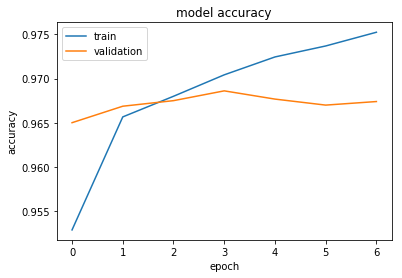

In [22]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Percentage accuracy of model

In [23]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 97.00%


f1, precision, and recall scores

In [24]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     19966
           1       0.99      0.95      0.97     19724

    accuracy                           0.97     39690
   macro avg       0.97      0.97      0.97     39690
weighted avg       0.97      0.97      0.97     39690



In [25]:
def predict_example(tweet):
    tweet_list = []
    tweet_list.append(tweet)
    cleaned_list = clean_tweets(tweet_list)
    sequence = tokenizer.texts_to_sequences(cleaned_list)
    data = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
    prediction = model.predict_classes(data)
    if prediction[0][0]:
        return True
    else:
        return False

tweet = "Depression is eating me up"
predict_example(tweet)

True

## Section 5: Comparing the Model to Base Line

In order to evaluate the effectiveness of the LSTM + CNN model, a logistic regression model is trained with the same train data and the same number of epochs, and tested with the same test data.

## 1. Logistic Regression Base Line Model

In [26]:
class LogReg:
    """
    Class to represent a logistic regression model.
    """

    def __init__(self, l_rate, epochs, n_features):
        """
        Create a new model with certain parameters.

        :param l_rate: Initial learning rate for model.
        :param epoch: Number of epochs to train for.
        :param n_features: Number of features.
        """
        self.l_rate = l_rate
        self.epochs = epochs
        self.coef = [0.0] * n_features
        self.bias = 0.0

    def sigmoid(self, score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.

        :param score: A real valued number to convert into a number between 0 and 1
        """
        if abs(score) > threshold:
            score = threshold * sign(score)
        activation = exp(score)
        return activation / (1.0 + activation)

    def predict(self, features):
        """
        Given an example's features and the coefficients, predicts the class.

        :param features: List of real valued features for a single training example.

        :return: Returns the predicted class (either 0 or 1).
        """
        value = sum([features[i]*self.coef[i] for i in range(len(features))]) + self.bias
        return self.sigmoid(value)

    def sg_update(self, features, label):
        """
        Computes the update to the weights based on a predicted example.

        :param features: Features to train on.
        :param label: Corresponding label for features.
        """
        yhat = self.predict(features)
        e = label - yhat
        self.bias = self.bias + self.l_rate * e * yhat * (1-yhat)
        for i in range(len(features)):
            self.coef[i] = self.coef[i] + self.l_rate * e * yhat * (1-yhat) * features[i]
        return

    def train(self, X, y):
        """
        Computes logistic regression coefficients using stochastic gradient descent.

        :param X: Features to train on.
        :param y: Corresponding label for each set of features.

        :return: Returns a list of model weight coefficients where coef[0] is the bias.
        """
        for epoch in range(self.epochs):
            for features, label in zip(X, y):
                self.sg_update(features, label)
        return self.bias, self.coef

def get_accuracy(y_bar, y_pred):
    """
    Computes what percent of the total testing data the model classified correctly.

    :param y_bar: List of ground truth classes for each example.
    :param y_pred: List of model predicted class for each example.

    :return: Returns a real number between 0 and 1 for the model accuracy.
    """
    correct = 0
    for i in range(len(y_bar)):
        if y_bar[i] == y_pred[i]:
            correct += 1
    accuracy = (correct / len(y_bar)) * 100.0
    return accuracy

#### Training the logistic regression model

In [27]:
logreg = LogReg(LEARNING_RATE, EPOCHS, len(data_train[0]))
bias_logreg, weights_logreg = logreg.train(data_train, labels_train)
y_logistic = [round(logreg.predict(example)) for example in data_test]

#### Getting the accuracy of the logistic regression model predicting the test data

In [28]:
accuracy_logistic = get_accuracy(y_logistic, labels_test)
print('Logistic Regression Accuracy: {:0.3f}'.format(accuracy_logistic))

Logistic Regression Accuracy: 49.836


## 2. K-Nearest Neighbors (KNN)

#### Training and Testing data

In [11]:
X_train = data_train
y_train = labels_train
X_test = data_test
y_test = labels_test

#### Feature Scaling

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Fitting Decision Tree Classification to the Training set

In [13]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

#### Predicting the Test set results

In [14]:
y_pred = classifier.predict(X_test)

score = accuracy_score(y_test, y_pred)
print(score)

0.6896021768159029


#### Making the Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[15047  4920]
 [ 7400 12324]]


#### Classification Report

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71     19967
           1       0.71      0.62      0.67     19724

    accuracy                           0.69     39691
   macro avg       0.69      0.69      0.69     39691
weighted avg       0.69      0.69      0.69     39691



## 3. Decision Tree

#### Training and Testing data

In [35]:
X_train = data_train
y_train = labels_train
X_test = data_test
y_test = labels_test

#### Feature Scaling

In [36]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Fitting Decision Tree Classification to the Training set

In [37]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

#### Predicting the Test set results

In [38]:
y_pred = classifier.predict(X_test)

score = accuracy_score(y_test, y_pred)
print(score)

0.8693877551020408


#### Making the Confusion Matrix

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[17355  2611]
 [ 2573 17151]]


#### Classification Report

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     19966
           1       0.87      0.87      0.87     19724

    accuracy                           0.87     39690
   macro avg       0.87      0.87      0.87     39690
weighted avg       0.87      0.87      0.87     39690



## 4. Support Vector Machine (SVM)

#### Training and Testing data

In [41]:
X_train = data_train
y_train = labels_train
X_test = data_test
y_test = labels_test

#### Feature Scaling

In [42]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Fitting SVM to the Training set

In [43]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(random_state=0)

#### Predicting the Test set results

In [44]:
y_pred = classifier.predict(X_test)

score = accuracy_score(y_test, y_pred)
print(score)

0.681708238851096


#### Making the Confusion Matrix

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[17942  2024]
 [10609  9115]]


#### Classification Report

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.90      0.74     19966
           1       0.82      0.46      0.59     19724

    accuracy                           0.68     39690
   macro avg       0.72      0.68      0.67     39690
weighted avg       0.72      0.68      0.67     39690

